# Aditya Dutta

## HW6

### Import Libraries

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

#### **1. Tree-Based Methods**

**(a) Download the APSFailure data from: https://archive.ics.uci.edu/ml/datasets/
 APS+Failure+at+Scania+Trucks . The dataset contains a training set and a test
 set. The training set contains 60,000 rows, of which 1,000 belong to the positive
 class and 171 columns, of which one is the class column. All attributes are nu
meric.**

- The dataset comprises data gathered from heavy Scania trucks during regular operation.
- The system of interest is the Air Pressure System (APS), which generates pressurized air used for various truck functions, such as braking and gear changes.
- The positive class represents instances of component failures specific to a part of the APS.
- The negative class includes trucks with failures in components not associated with the APS.
- The data is a subset of the complete dataset, selected by experts.


In [4]:
import warnings
warnings.filterwarnings("ignore")

train_data_path = "./../data/aps_failure_training_set.csv"
test_data_path = "./../data/aps_failure_test_set.csv"

train_df = pd.read_csv(train_data_path, sep=',', skiprows=20, na_values='na')
test_df = pd.read_csv(test_data_path, sep=',', skiprows=20, na_values='na')

for df in [train_df, test_df]:
    df['class'].replace({'neg': 0, 'pos': 1}, inplace=True)


**(b) Data Preparation**

**This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.**

**i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.**

<u>***In this exercise, we will use mean substitution for data imputation.***</u>

In [6]:
missing_features_train = train_df.isna().mean()
features_for_imputation = missing_features_train[missing_features_train > 0].index

# Prompt used: "What are the best practices for imputing missing values in machine learning datasets?", (3 lines), GPT-Generated
# Response:
# Handling missing data requires careful consideration to prevent data leakage and ensure model robustness. Using SimpleImputer:
# mean_imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
# Best practice involves fitting the imputer on the training set to learn the mean values, and then transforming both the training 
# and test sets using the learned parameters.

# Using mean substitution for imputation
mean_imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

# Fit and transform
train_df[features_for_imputation] = mean_imputer.fit_transform(train_df[features_for_imputation])
test_df[features_for_imputation] = mean_imputer.transform(test_df[features_for_imputation])

# Combine 
combined_imputed_df = pd.concat([train_df, test_df])

**ii. For each of the 170 features, calculate the coefficient of variation $CV = \frac{s}{m}$ ,where s is sample standard deviation and m is sample mean.**

In [8]:
summary_stats = combined_imputed_df.describe()
std_numerator = summary_stats.loc['std']
mean_denominator = summary_stats.loc['mean']
summary_stats.loc['Coefficient of Variation'] = std_numerator / mean_denominator
summary_stats.loc[['std', 'mean', 'Coefficient of Variation']]

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
std,0.133285,264736.613729,1.580477,7.726379e+08,3.113846e+07,150.191549,197.318607,18331.517120,50701.585116,170924.260833,...,1.170523e+06,548744.193714,1.183134e+06,1.145078e+06,1.091658e+06,1.697870e+06,466560.930263,48476.793230,4.082618,9.999582
mean,0.018092,61159.759395,0.716006,3.564159e+08,1.605445e+05,6.740408,10.843470,200.670596,1202.169357,9684.979217,...,4.495299e+05,213221.946448,4.505920e+05,4.005447e+05,3.378143e+05,3.475465e+05,139883.538441,8424.574202,0.085444,0.218756
Coefficient of Variation,7.367051,4.328608,2.207351,2.167798e+00,1.939553e+02,22.282263,18.196998,91.351287,42.175077,17.648387,...,2.603882e+00,2.573582,2.625732e+00,2.858802e+00,3.231533e+00,4.885304e+00,3.335353,5.754213,47.781107,45.711130


**iii. Plot a correlation matrix for your features using pandas or any other tool.**

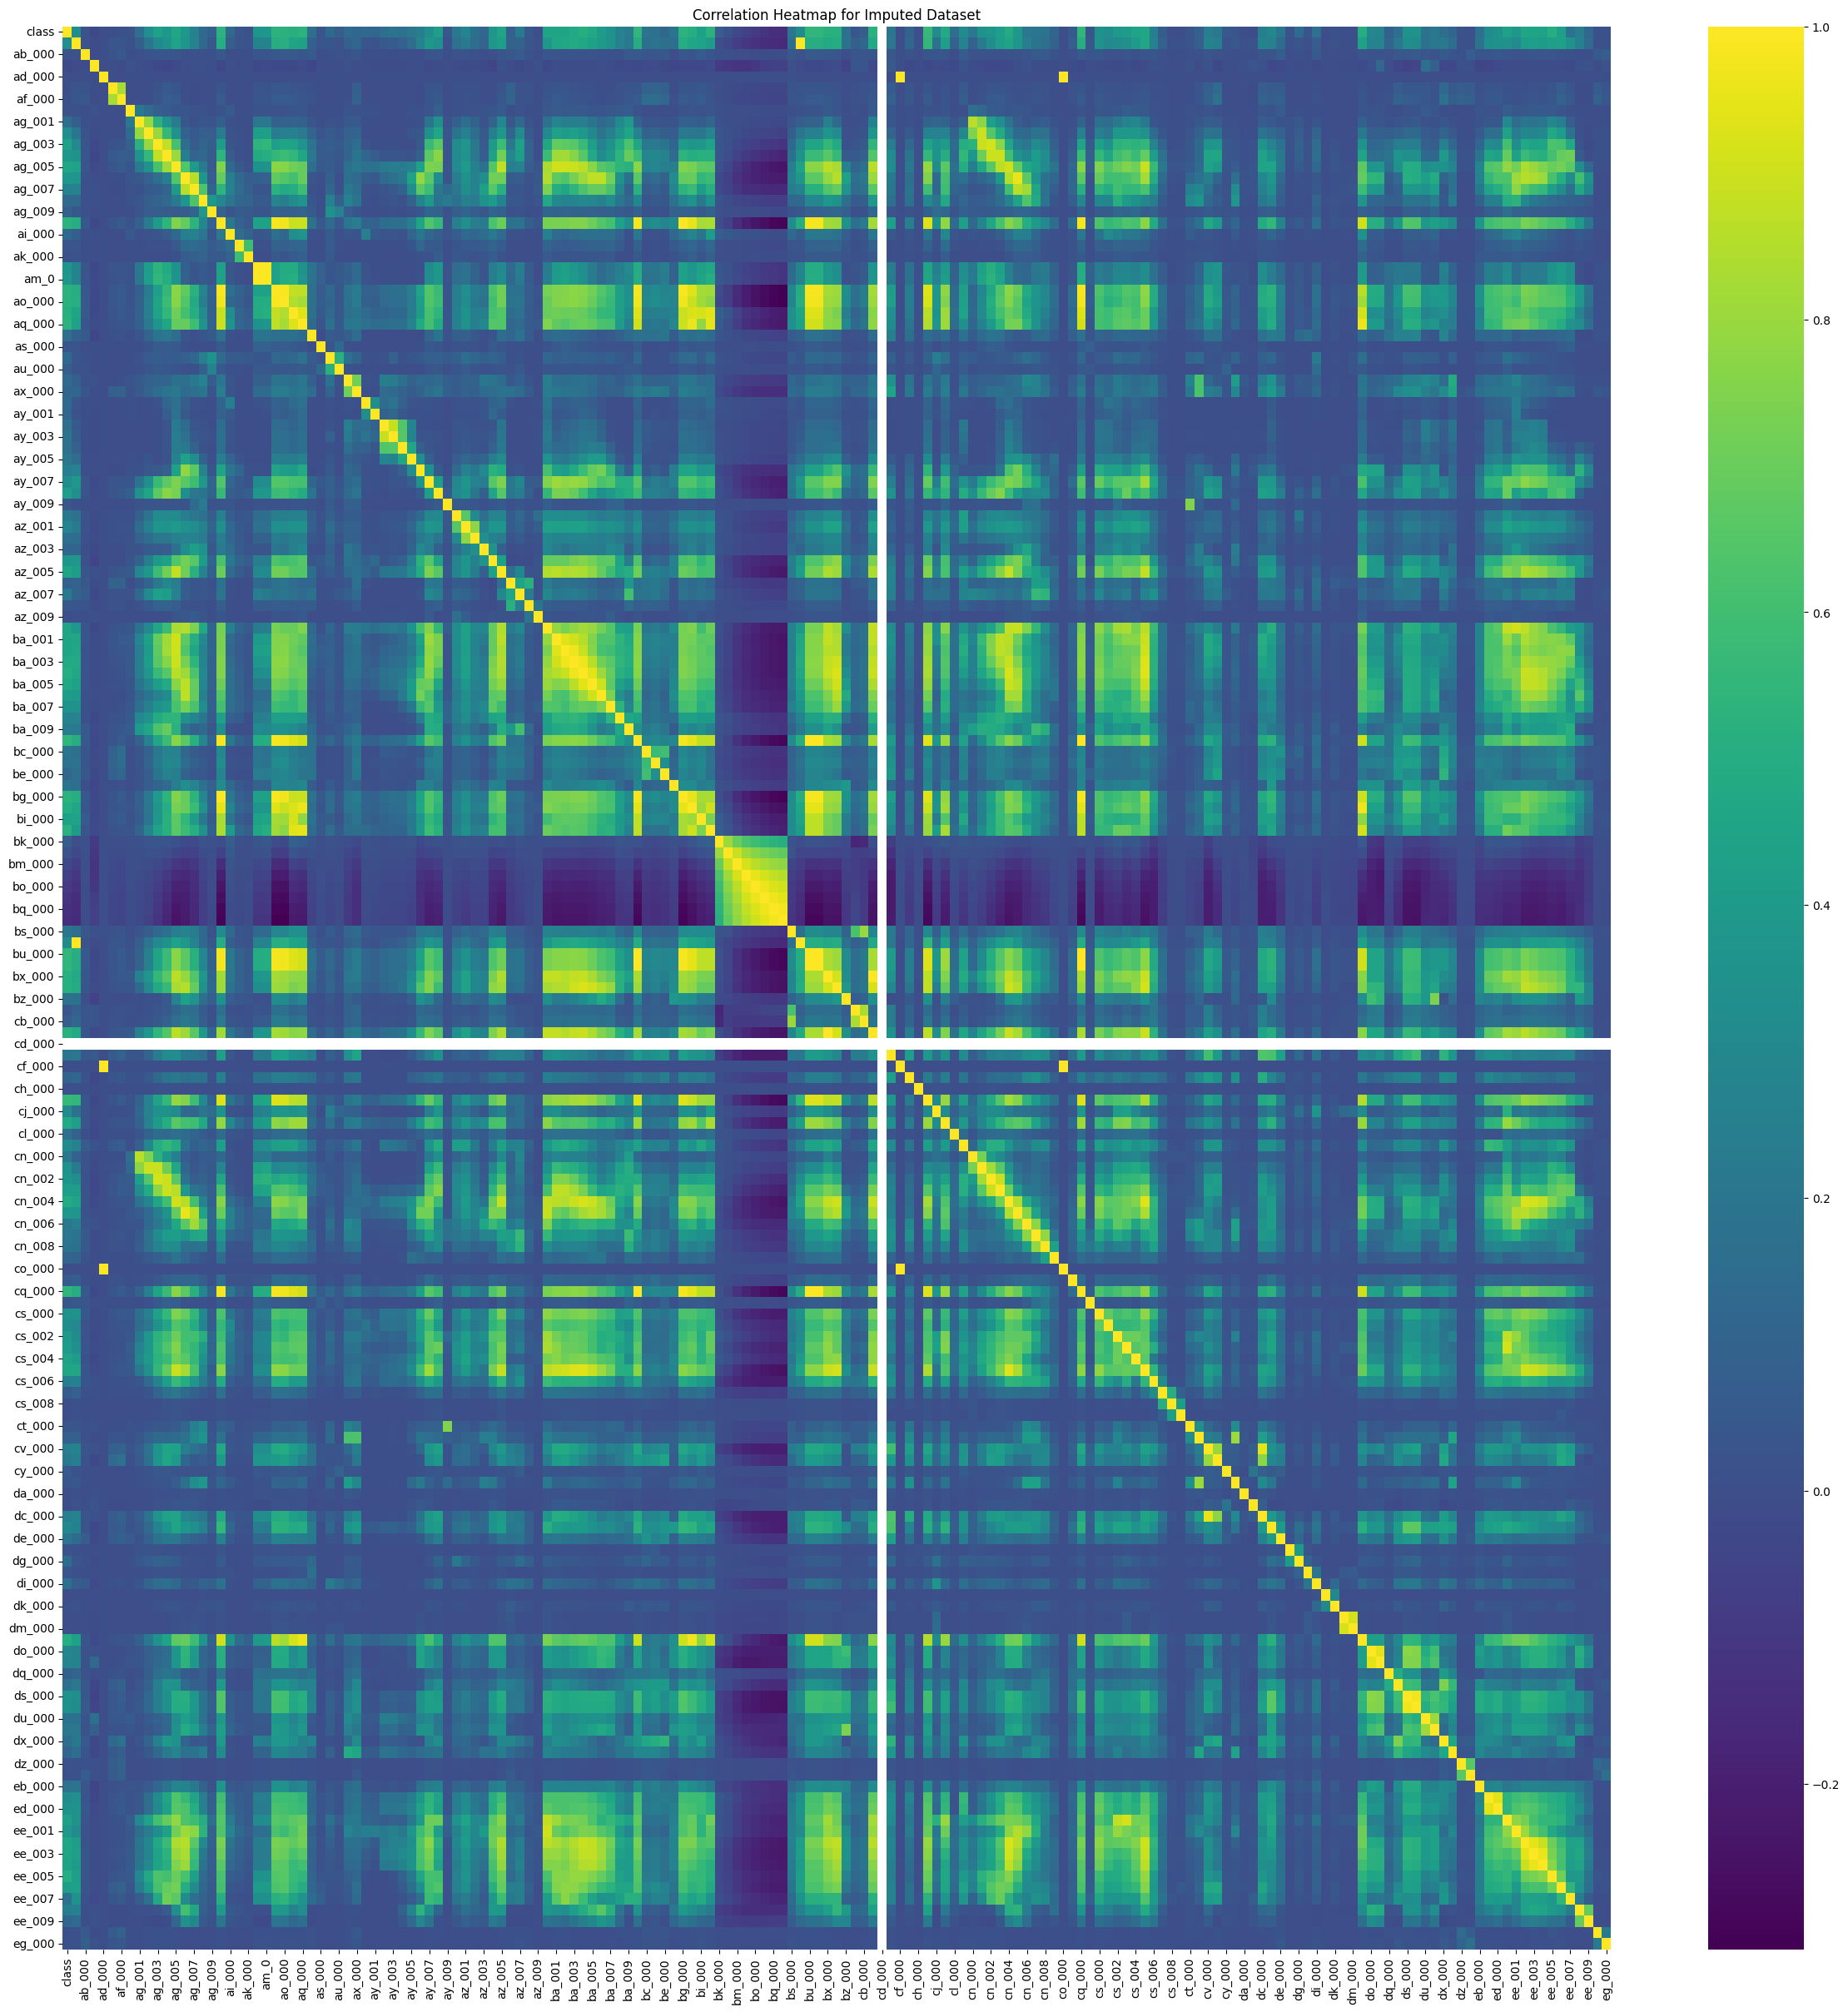

In [10]:
plt.figure(figsize=(30, 30))
correlation_matrix = combined_imputed_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')  
plt.title("Correlation Heatmap for Imputed Dataset")
plt.show()

**iv. Pick $\lfloor 170 \rfloor$ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.**

In [14]:
num_features_to_select = math.floor(math.sqrt(170))
top_cv_features = summary_stats.loc['Coefficient of Variation'].sort_values(ascending=False).head(num_features_to_select)
top_cv_features

cf_000    194.438323
co_000    194.089168
ad_000    193.955307
cs_009    193.045035
dj_000    120.084900
df_000    116.138172
as_000    114.464381
dh_000    111.946396
ag_000     91.351287
au_000     86.293581
ak_000     78.559993
az_009     77.894525
ay_009     77.457761
Name: Coefficient of Variation, dtype: float64

**Plotting the scatterplots**

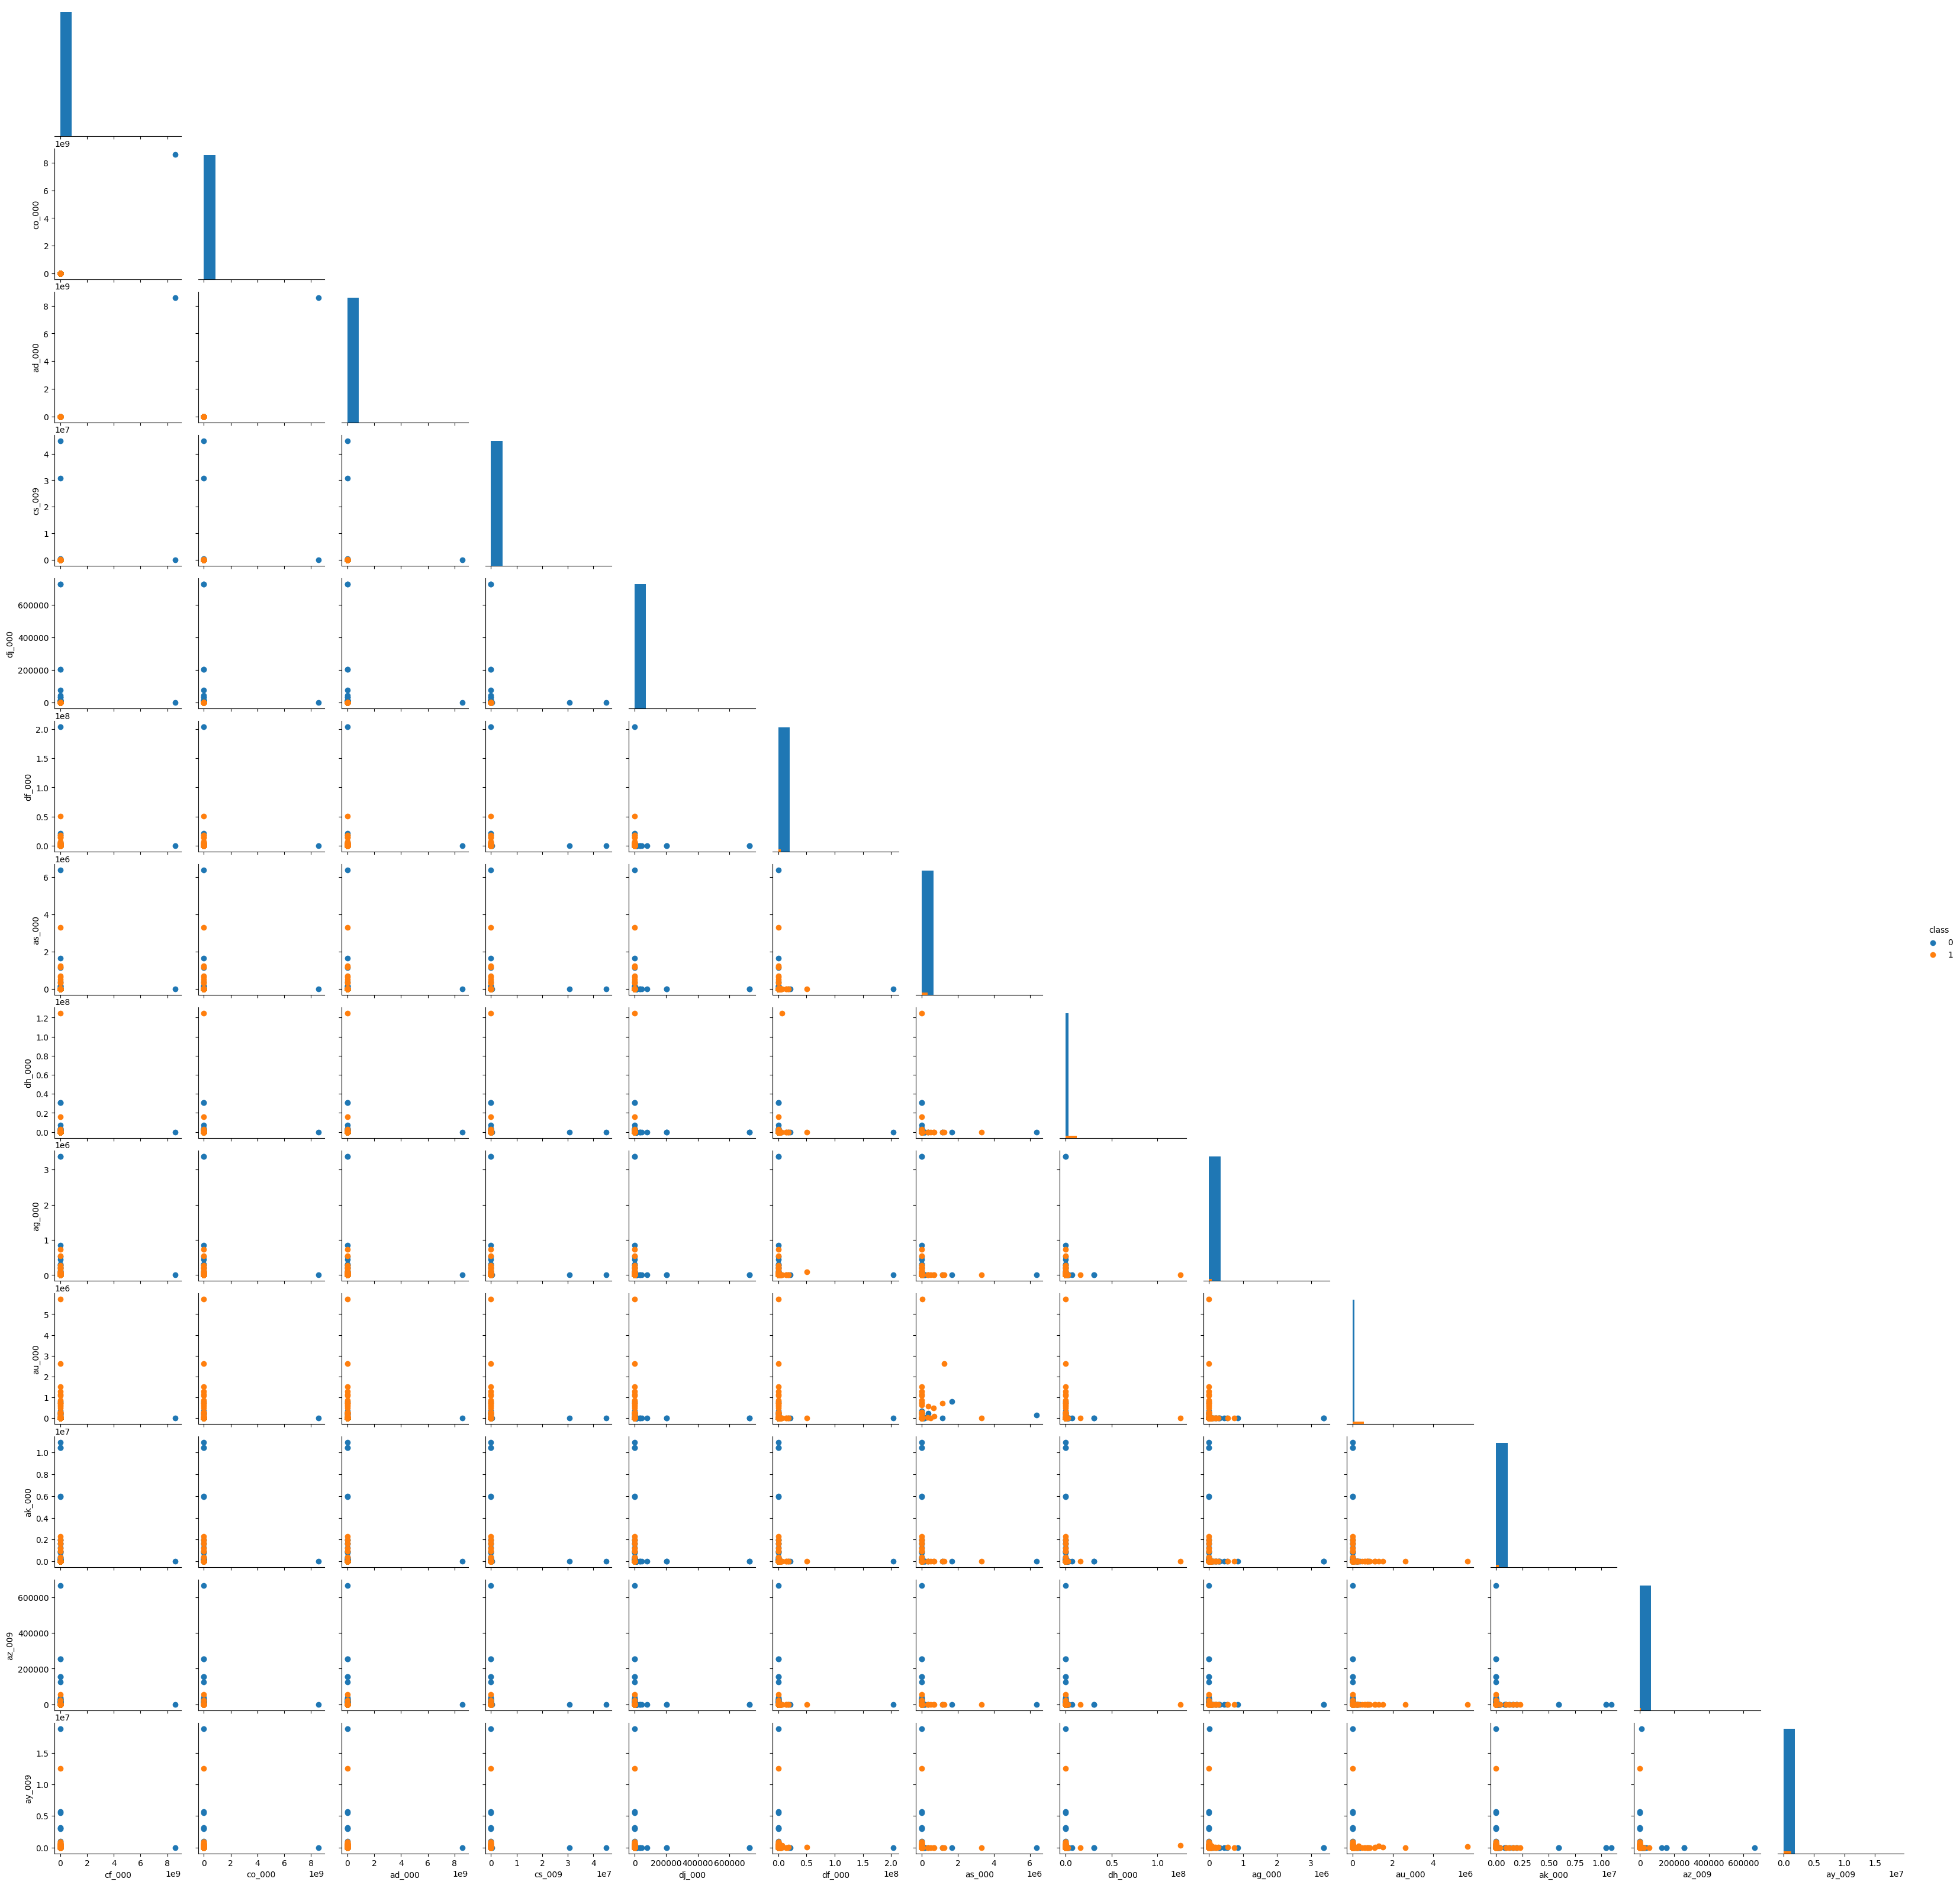

In [16]:
# Useful website for code: https://seaborn.pydata.org/generated/seaborn.PairGrid.html
# Extracting feature names with the highest coefficient of variation and adding the target variable
top_cv_feature_names = top_cv_features.index.tolist() + ['class']
pair_grid = sns.PairGrid(
    combined_imputed_df[top_cv_feature_names], 
    diag_sharey=False, 
    corner=True, 
    hue='class'
)
pair_grid.map_diag(plt.hist)  
pair_grid.map_offdiag(plt.scatter) 
pair_grid.add_legend()


**Plotting boxplots**

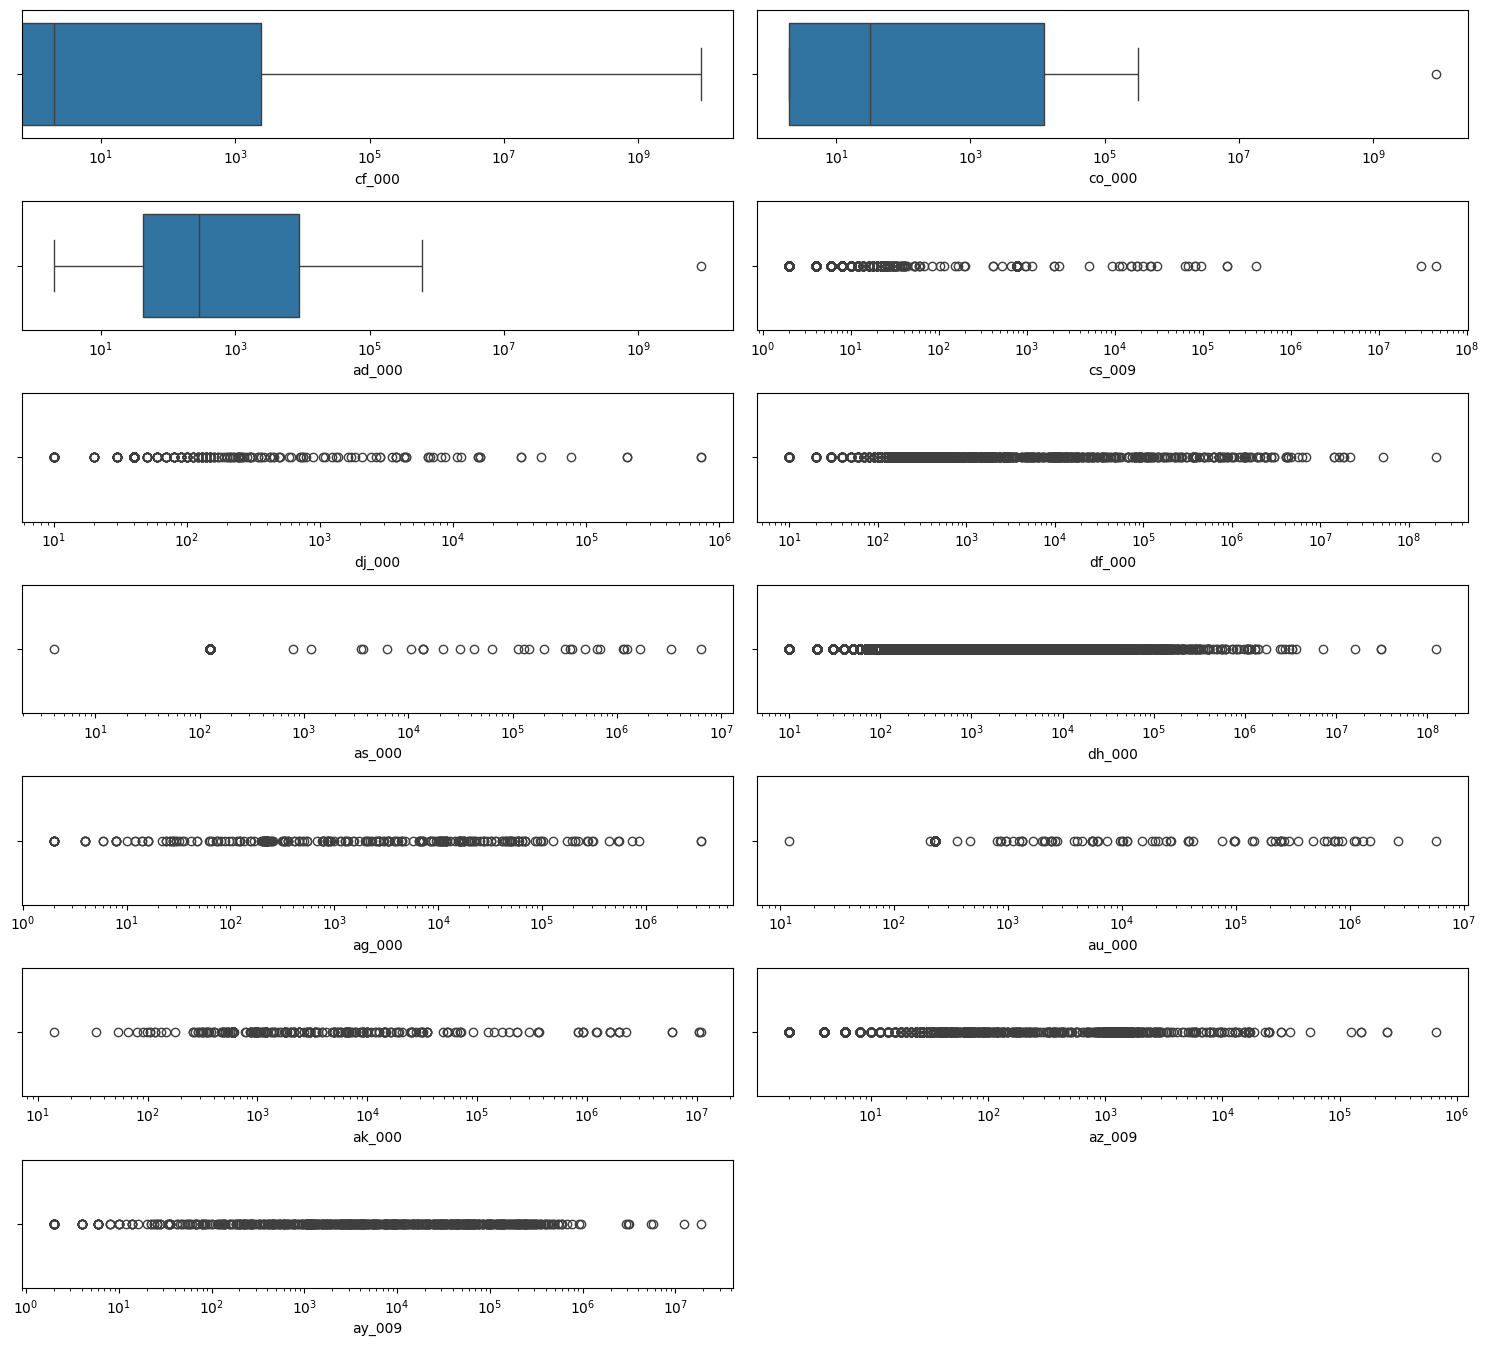

In [18]:
plt.figure(figsize=(15, 15))
num_rows, num_cols = 8, 2

# Loop 
for idx, feature in enumerate(top_cv_features.index):
    ax = plt.subplot(num_rows, num_cols, idx + 1)  
    ax.set_xscale("log")  
    sns.boxplot(x=feature, data=combined_imputed_df, ax=ax) 

plt.tight_layout() 
plt.show()

**Analysis**

- oDifficult to draw any concluisons from the scatterplots. 
- With the boxplots, comparisons are easier to make.

**v. Determine the number of positive and negative data. Is this data set imbalanced?**

In [20]:
def count_classes(df, dataset_name):
    positive_count = df[df['class'] == 1]['class'].count()
    negative_count = df[df['class'] == 0]['class'].count()
    print(f"{dataset_name} dataset:")
    print(f'Number of positive classes: {positive_count}')
    print(f'Number of negative classes: {negative_count}\n')

count_classes(train_df, "Training")
count_classes(test_df, "Test")

Training dataset:
Number of positive classes: 1000
Number of negative classes: 59000

Test dataset:
Number of positive classes: 375
Number of negative classes: 15625



**(c) Train a random forest to classify the data set. Do NOT compensate for class
 imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and
 misclassi cation for training and test sets and report them (You may use pROC
 package). Calculate Out of Bag error estimate for your random forset and compare
 it to the test error**

In [22]:
# Splitting data into features and target variables
train_x, train_y = train_df.iloc[:, 1:], train_df['class']
test_x, test_y = test_df.iloc[:, 1:], test_df['class']

# Random Forest Classifier 
rf_params = {
    'max_depth': 5,
    'random_state': 52,
    'oob_score': True
}
rf_classifier = RandomForestClassifier(**rf_params)
rf_classifier.fit(train_x, train_y)

# Calculating Out-Of-Bag 
oob_score_rf = rf_classifier.oob_score_
oob_error_rf = round(1 - oob_score_rf, 4)
print("APS Training Data OOB Score:", oob_score_rf)
print("APS Training Data OOB Error:", oob_error_rf)

APS Training Data OOB Score: 0.9908
APS Training Data OOB Error: 0.0092


The confusion matrix for the training set is shown below:
[[58973    27]
 [  434   566]]
The classification accuracy for the training dataset is: 0.9923
The classification error for the training dataset is: 0.0077


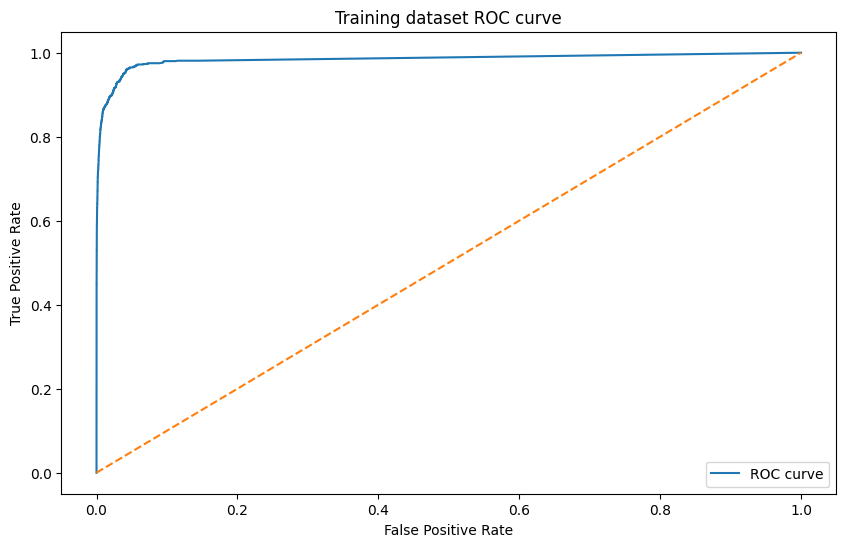

ROC AUC Score: 0.9844


In [24]:
from sklearn import metrics
def evaluate_model_performance(y_true, y_pred, y_pred_proba):
    # Calculating confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = round(metrics.accuracy_score(y_true, y_pred), 4)
    classification_error = round(1 - accuracy, 4)
    
    
    print("The confusion matrix for the training set is shown below:")
    print(conf_matrix)
    print("The classification accuracy for the training dataset is:", accuracy)
    print("The classification error for the training dataset is:", classification_error)
    
    return accuracy, classification_error, conf_matrix

def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1], pos_label=1)
    auc_score = round(auc(fpr, tpr), 4)
    
    # Plotting the ROC curve
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(fpr, tpr, label='ROC curve')
    ax.plot([0, 1], [0, 1], "--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.set_title("Training dataset ROC curve")
    plt.show()
    
    return auc_score

# Pred on training data
train_y_pred = rf_classifier.predict(train_x)
train_pred_proba = rf_classifier.predict_proba(train_x)
train_accuracy, classification_err, conf_matrix = evaluate_model_performance(train_y, train_y_pred, train_pred_proba)

roc_auc_score = plot_roc_curve(train_y, train_pred_proba)
print("ROC AUC Score:", roc_auc_score)

The confusion matrix for the training set is shown below:
[[15613    12]
 [  176   199]]
The classification accuracy for the training dataset is: 0.9882
The classification error for the training dataset is: 0.0118


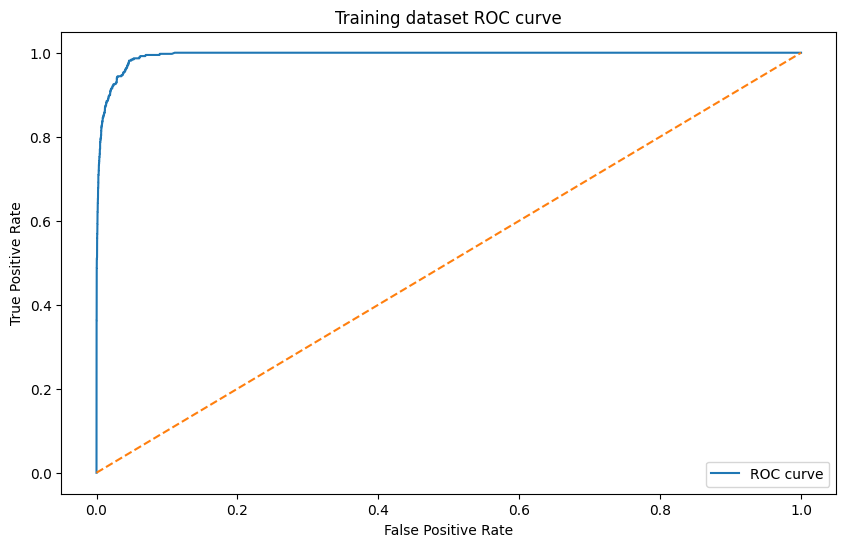

Test ROC AUC Score: 0.9942


In [26]:
# Pred on testing data
test_y_pred = rf_classifier.predict(test_x)
test_pred_proba = rf_classifier.predict_proba(test_x)


test_accuracy, classification_err_test, conf_matrix_test = evaluate_model_performance(test_y, test_y_pred, test_pred_proba)

roc_auc_test = plot_roc_curve(test_y, test_pred_proba)
print("Test ROC AUC Score:", roc_auc_test)

**(d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 2c. Compare the results with those of 2c.**

In [30]:
# Parameters for the Random Forest
tree_max_depth = 5
tree_random_state = 50  # For reproducibility

# Useful website for code: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# Prompt used: "How can I handle class imbalance in RandomForest using scikit-learn?", 5 lines), GPT-Generated
# Response:
# In imbalanced datasets, setting `class_weight="balanced"` in RandomForest accounts for class imbalance by assigning
# weights inversely proportional to class frequencies. Example:
# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(max_depth=5, class_weight="balanced", oob_score=True, random_state=42)
# model.fit(X_train, y_train)
# Using `oob_score=True` provides an out-of-bag estimate, offering a reliable performance measure without additional
# cross-validation. This setup ensures better handling of minority classes and model robustness.


# Function to initialize and fit a Random Forest classifier
def initialize_and_fit_rf(max_depth, random_state, class_weight=None, oob_score=False):
    classifier = RandomForestClassifier(
        max_depth=max_depth,
        random_state=random_state,
        class_weight=class_weight,
        oob_score=oob_score
    )
    classifier.fit(train_x, train_y)
    return classifier

rf_classifier_balanced = initialize_and_fit_rf(
    max_depth=tree_max_depth,
    random_state=tree_random_state,
    class_weight="balanced",
    oob_score=True
)

In [32]:
def calculate_oob_metrics(classifier):
    oob_score = classifier.oob_score_
    oob_error = round(1 - oob_score, 4)
    print("APS Training Data OOB Score (Balanced):", oob_score)
    print("APS Training Data OOB Error (Balanced):", oob_error)
    return oob_score, oob_error
oob_score_balanced, oob_error_balanced = calculate_oob_metrics(rf_classifier_balanced)

APS Training Data OOB Score (Balanced): 0.9581
APS Training Data OOB Error (Balanced): 0.0419


The confusion matrix for the training set is shown below:
[[56572  2428]
 [   32   968]]
The classification accuracy for the training dataset is: 0.959
The classification error for the training dataset is: 0.041


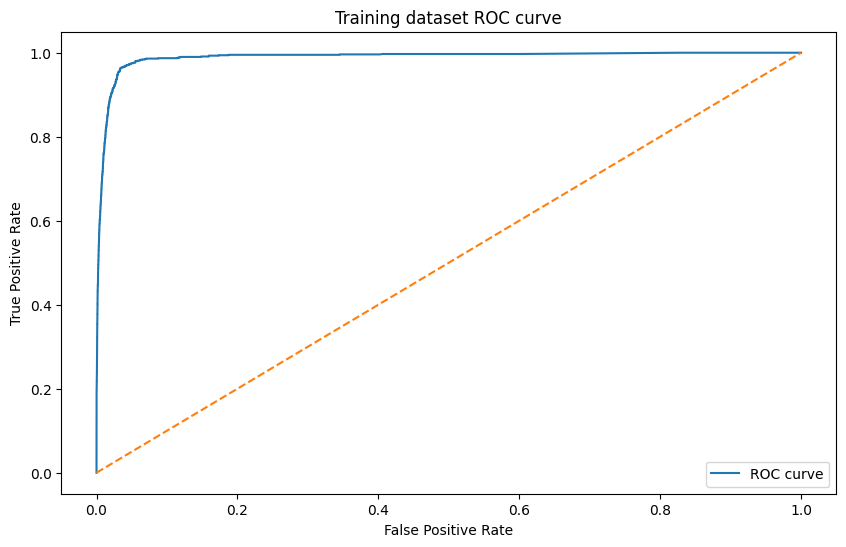

Balanced Training ROC AUC Score: 0.9891


In [34]:
train_y_pred_balanced = rf_classifier_balanced.predict(train_x)
train_pred_proba_balanced = rf_classifier_balanced.predict_proba(train_x)

train_accuracy_balanced, classification_err_balanced, conf_matrix_balanced = evaluate_model_performance(
    train_y, train_y_pred_balanced, train_pred_proba_balanced
)

roc_auc_balanced = plot_roc_curve(train_y, train_pred_proba_balanced)
print("Balanced Training ROC AUC Score:", roc_auc_balanced)

The confusion matrix for the training set is shown below:
[[15007   618]
 [   13   362]]
The classification accuracy for the training dataset is: 0.9606
The classification error for the training dataset is: 0.0394


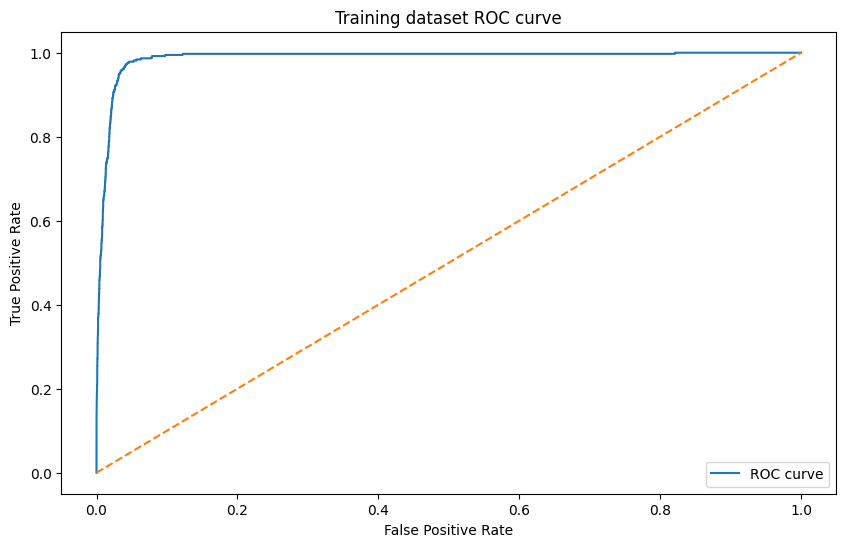

Balanced Test ROC AUC Score: 0.9877


In [36]:
test_y_pred_balanced = rf_classifier_balanced.predict(test_x)
test_pred_proba_balanced = rf_classifier_balanced.predict_proba(test_x)
test_accuracy_balanced, classification_err_test_balanced, conf_matrix_test_balanced = evaluate_model_performance(
    test_y, test_y_pred_balanced, test_pred_proba_balanced
)

roc_auc_test_balanced = plot_roc_curve(test_y, test_pred_proba_balanced)
print("Balanced Test ROC AUC Score:", roc_auc_test_balanced)

**The Training OOB error**
- is 0.8% for the unbalanced class.
- is 4.19% for the balanced class.
  
**The Testing Misclassification Error**
- is 1.18% for the unbalanced class.
- is 3.94% for the balanced class.
  
**Conclusion:**
- The unbalanced class gives higher testing accuracy compared to the balanced class as seen by lower misclassification erroo
- But thhe conf matrix indicates that accuracy of predicting the positive (1) class is significantly improved in the balanced dataset compared to the unbalanced one.

**(e) XGBoost and Model Trees**

**In the case of a univariate tree, only one input dimension is used at a tree split.
In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision
rule. In model trees, a (linear) model that relies on all of the variables is used to determine the
P split of that node (i.e. instead of using $X_{j} > s$  as the decision rule, one has $\sum\limits_{j}\beta_{j}X_{j} > s$ as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use $\mathscr{L}_{1}$ -penalized logistic regression at each node.** 

- **You can use XGBoost to fit the model tree. Determine $\alpha$ (the regularization term) using cross-validation.** 

- **Train the model for the APS data set without compensation for class imbalance.** 

- **Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error.** 

- **Report the Confusion Matrix, ROC, and AUC for training and test sets.**

In [40]:
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

# Function to perform cross-validation for different alpha values
def perform_xgb_cross_validation(alpha_values, xgb_objective, xgb_random_state, k_folds, scoring_metric):
    cross_val_results = {}
    
    for alpha in alpha_values:
        xgb_model = xgb.XGBClassifier(objective=xgb_objective, reg_alpha=alpha, random_state=xgb_random_state)
        cross_val_scores = cross_val_score(
            xgb_model, train_x, train_y, 
            cv=KFold(k_folds, shuffle=True, random_state=xgb_random_state),
            scoring=scoring_metric
        )
        cross_val_results[alpha] = sum(abs(cross_val_scores)) / len(cross_val_scores)
    
    return cross_val_results

# Function to find the alpha with the lowest cross-validation error
def find_best_alpha(cross_val_results):
    min_error = float('inf')
    best_alpha_value = None

    for alpha, error in cross_val_results.items():
        if error < min_error:
            min_error = error
            best_alpha_value = alpha

    return best_alpha_value

alpha_list = [0.001, 0.01, 1, 10]

# Config
xgb.set_config(verbosity=0)
xgb_objective = 'reg:logistic'
xgb_random_state = 100
k_folds = 5
xgb_scoring = "neg_mean_squared_error"

#cross val
cross_val_xgb_results = perform_xgb_cross_validation(alpha_list, xgb_objective, xgb_random_state, k_folds, xgb_scoring)

best_alpha = find_best_alpha(cross_val_xgb_results)

print('XGBoost alpha value with the lowest Cross-Validation Error:', best_alpha)

XGBoost alpha value with the lowest Cross-Validation Error: 0.001


In [58]:
xgb_model_train = xgb.XGBClassifier(objective=xgb_objective, reg_alpha=10, random_state=xgb_random_state)
xgb_model_train.fit(train_x, train_y)
y_pred_train = xgb_model_train.predict(train_x)

xgb_train_mse = mean_squared_error(train_y, y_pred_train)
print('XGBoost Train MSE:', xgb_train_mse)

XGBoost Train MSE: 0.002116666666666667


In [62]:
print("Confusion Matrix for the Training Set:")
conf_matrix_df = pd.DataFrame(
    confusion_matrix(train_y, y_pred_train),
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['Actual Negative', 'Actual Positive']
)

conf_matrix_df

Confusion Matrix for the Training Set:


,Predicted Negative,Predicted Positive
Actual Negative,58986,14
Actual Positive,113,887


In [66]:
from sklearn.metrics import roc_auc_score
print("This is the Training ROC AUC Score")
print(roc_auc_score(train_y, y_pred_train))

This is the Training ROC AUC Score
0.9433813559322034


In [70]:
xgb_model = xgb.XGBClassifier(objective=xgb_objective, reg_alpha=10, random_state=xgb_random_state)
xgb_model.fit(train_x, train_y)
y_pred_test = xgb_model.predict(test_x)

xgb_test_mse = mean_squared_error(test_y, y_pred_test)
print('XGBoost Test MSE:', xgb_test_mse)

XGBoost Test MSE: 0.0066875


In [74]:
def print_confusion_matrix(y_true, y_pred, dataset_name="Test"):
    print(f"This is the Confusion Matrix for the {dataset_name} Set:")
    conf_matrix_df = pd.DataFrame(
        confusion_matrix(y_true, y_pred),
        columns=['Predicted Negative', 'Predicted Positive'],
        index=['Actual Negative', 'Actual Positive']
    )
    print(conf_matrix_df)
    return conf_matrix_df

conf_matrix_test_df = print_confusion_matrix(test_y, y_pred_test, dataset_name="Test")

This is the Confusion Matrix for the Test Set:
                 Predicted Negative  Predicted Positive
Actual Negative               15607                  18
Actual Positive                  89                 286


In [80]:
from sklearn.metrics import roc_auc_score

print("This is the Test ROC AUC Score")
test_roc_auc_score = roc_auc_score(test_y, xgb_model.predict_proba(test_x)[:, 1])
print(test_roc_auc_score)

This is the Test ROC AUC Score
0.9961296213333333


**(f)**

**Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.Train XGBoost with $\mathscr{L}_{1}$ -penalized logistic regression at each node using the pre-processed data and repeat 2e.Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.**


In [82]:
# (https://machinelearningmastery.com/xgboost-for-imbalanced-classification/) 
# and (https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) was used for this question.
#For doing correct cross validation, this (https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7) was used.
#For understanding SMOTE in XGBoost, this tutorial was used(https://blog.dominodatalab.com/credit-card-fraud-detection-using-xgboost-smote-and-threshold-moving). Code was used from here to answer this question.

import random
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from datetime import datetime
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, StratifiedKFold, GridSearchCV
import xgboost as xgb
from xgboost import XGBClassifier

# Prompt used: "How to balance an imbalanced dataset using SMOTE and optimize XGBoost with GridSearchCV?", (4 lines), GPT-Generated
# Response:
# SMOTE (Synthetic Minority Over-sampling Technique) is used to create synthetic samples for the minority class to balance the dataset:
# X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
# To tune XGBoost parameters, use GridSearchCV with StratifiedKFold to ensure balanced cross-validation splits:
# model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
# grid_search = GridSearchCV(estimator=model, param_grid=params, scoring="roc_auc", cv=StratifiedKFold(3))

# Applying SMOTE to balance the training data
X_train_smote, y_train_smote = SMOTE(random_state=1234).fit_resample(train_x, train_y)

# Function to perform XGBoost hyperparameter search
def xgboost_search(X, y, search_verbose=0):
    # Parameter grid for hyperparameter tuning
    params = {
        "gamma": [1, 1.5],
        "max_depth": [3, 4],
        "min_child_weight": [100],
        "subsample": [0.6, 1.0],
        "colsample_bytree": [0.6, 1.0],
        "learning_rate": [0.1, 0.01]
    }
    xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

    grid_search = GridSearchCV(
        estimator=xgb_model, 
        param_grid=params, 
        scoring="roc_auc", 
        n_jobs=1, 
        cv=skf.split(X, y), 
        verbose=search_verbose
    )
    grid_search.fit(X, y)

    print("Best estimator:", grid_search.best_estimator_)
    print("Parameters:", grid_search.best_params_)
    print("Highest AUC: %.2f" % grid_search.best_score_)

    return grid_search.best_params_

sampled_indices = random.sample(range(len(X_train_smote)), 5000)
model_params = xgboost_search(X_train_smote.iloc[sampled_indices, :], y_train_smote.iloc[sampled_indices])

Best estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Parameters: {'colsample_bytree': 0.6, 'gamma': 1.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 100, 'subsample': 1.0}
Highest AUC: 0.99


In [84]:
xgb_final_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False
)
xgb_final_model.set_params(**model_params)
xgb_final_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=100, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

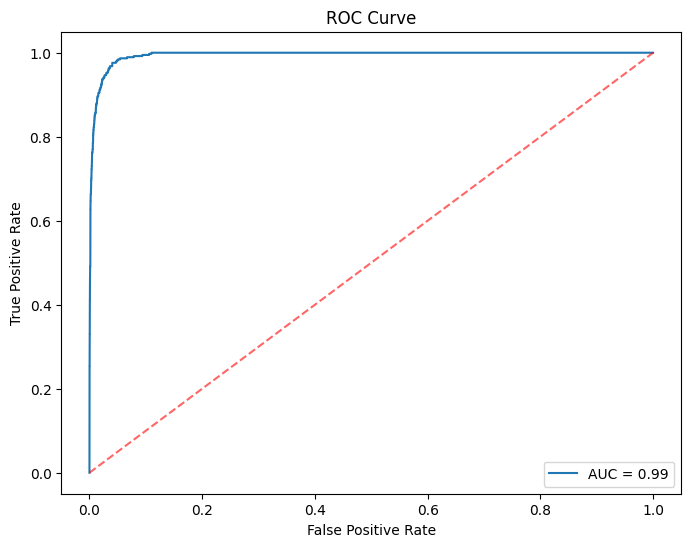

In [86]:
y_pred_proba = xgb_final_model.predict_proba(test_x)[:, 1]

fp_rate, tp_rate, thresholds = metrics.roc_curve(test_y, y_pred_proba)
roc_auc_score = metrics.auc(fp_rate, tp_rate)

plt.figure(figsize=(8, 6))
plt.plot(fp_rate, tp_rate, label=f"AUC = {roc_auc_score:.2f}")
plt.plot([0, 1], [0, 1], "r--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [92]:
y_pred_test_final = xgb_final_model.predict(test_x)
conf_matrix_test_final_df = print_confusion_matrix(test_y, y_pred_test_final, dataset_name="Test")


This is the Confusion Matrix for the Test Set:
                 Predicted Negative  Predicted Positive
Actual Negative               15347                 278
Actual Positive                  34                 341


In [96]:
from sklearn.metrics import roc_auc_score

print("This is the Test ROC AUC Score")
print(roc_auc_score(test_y, y_pred_test_final))

This is the Test ROC AUC Score
0.9457706666666666


**Comparison**

-  What is the difference in performance on the test set between using SMOTE AND NOT USING IT
- <u>USING SMOTE</u>, we got 341 out of 375 positive values correct (90%)
- <u>USING IMBALANCED dataset</u>, we got 286 out of 375 positive values correct (76%)
- From preliminary analysis, it shows that SMOTE is necessary for this imbalanced dataset.
- However, further hyperparameter tuning and model selection is needed to strengthen our conclusions.

**2. ISLR 6.6.3**

**(a) As we increase s from 0, the training RSS will:**

<u>ANS: (iv) Steadily decrease.</u> 

When s is 0, training RSS is at its maximum.

As s increases, the restriction on beta decreases model becomes more flexible and the RSS reduces until we reach the least squares answer, when s is extremely large.

**(b) Repeat (a) for test RSS.**

 <u>ANS: (ii). Decrease initially, and then eventually start increasing in a U shape.</u>

- At $s = 0$, the test RSS starts at its max value. So increasing $s$ initially decreases the test RSS.
- As $s$ becomes larger the model begins to overfit to the training data and this gives  poorer performance on the test set and causes the test RSS to rise.

**(c) Repeat (a) for variance.**

<u>ANS: (iii). Steadily increase.</u>

As we increase the value of s, the model flexibility increases. This will lead to the model overfitting to the training set. bUT this overfitting is likely to lead to poor performance on the test set and may increase the variance. 

**(d) Repeat (a) for (squared) bias.**

<u>ANS: (iv) Steadily decrease.</u>

As we increase the value of s, the model flexibility increases and will fit training data better, which will lead to a reduction in the bias. Hence, the squared bias will also decrease.

**(e) Repeat (a) for the irreducible error.**

The answer is <u>v. Remain constant.</u>

Irreducible error is the error which can never be removed and is independent of our model.

**3. ISLR 6.6.5**

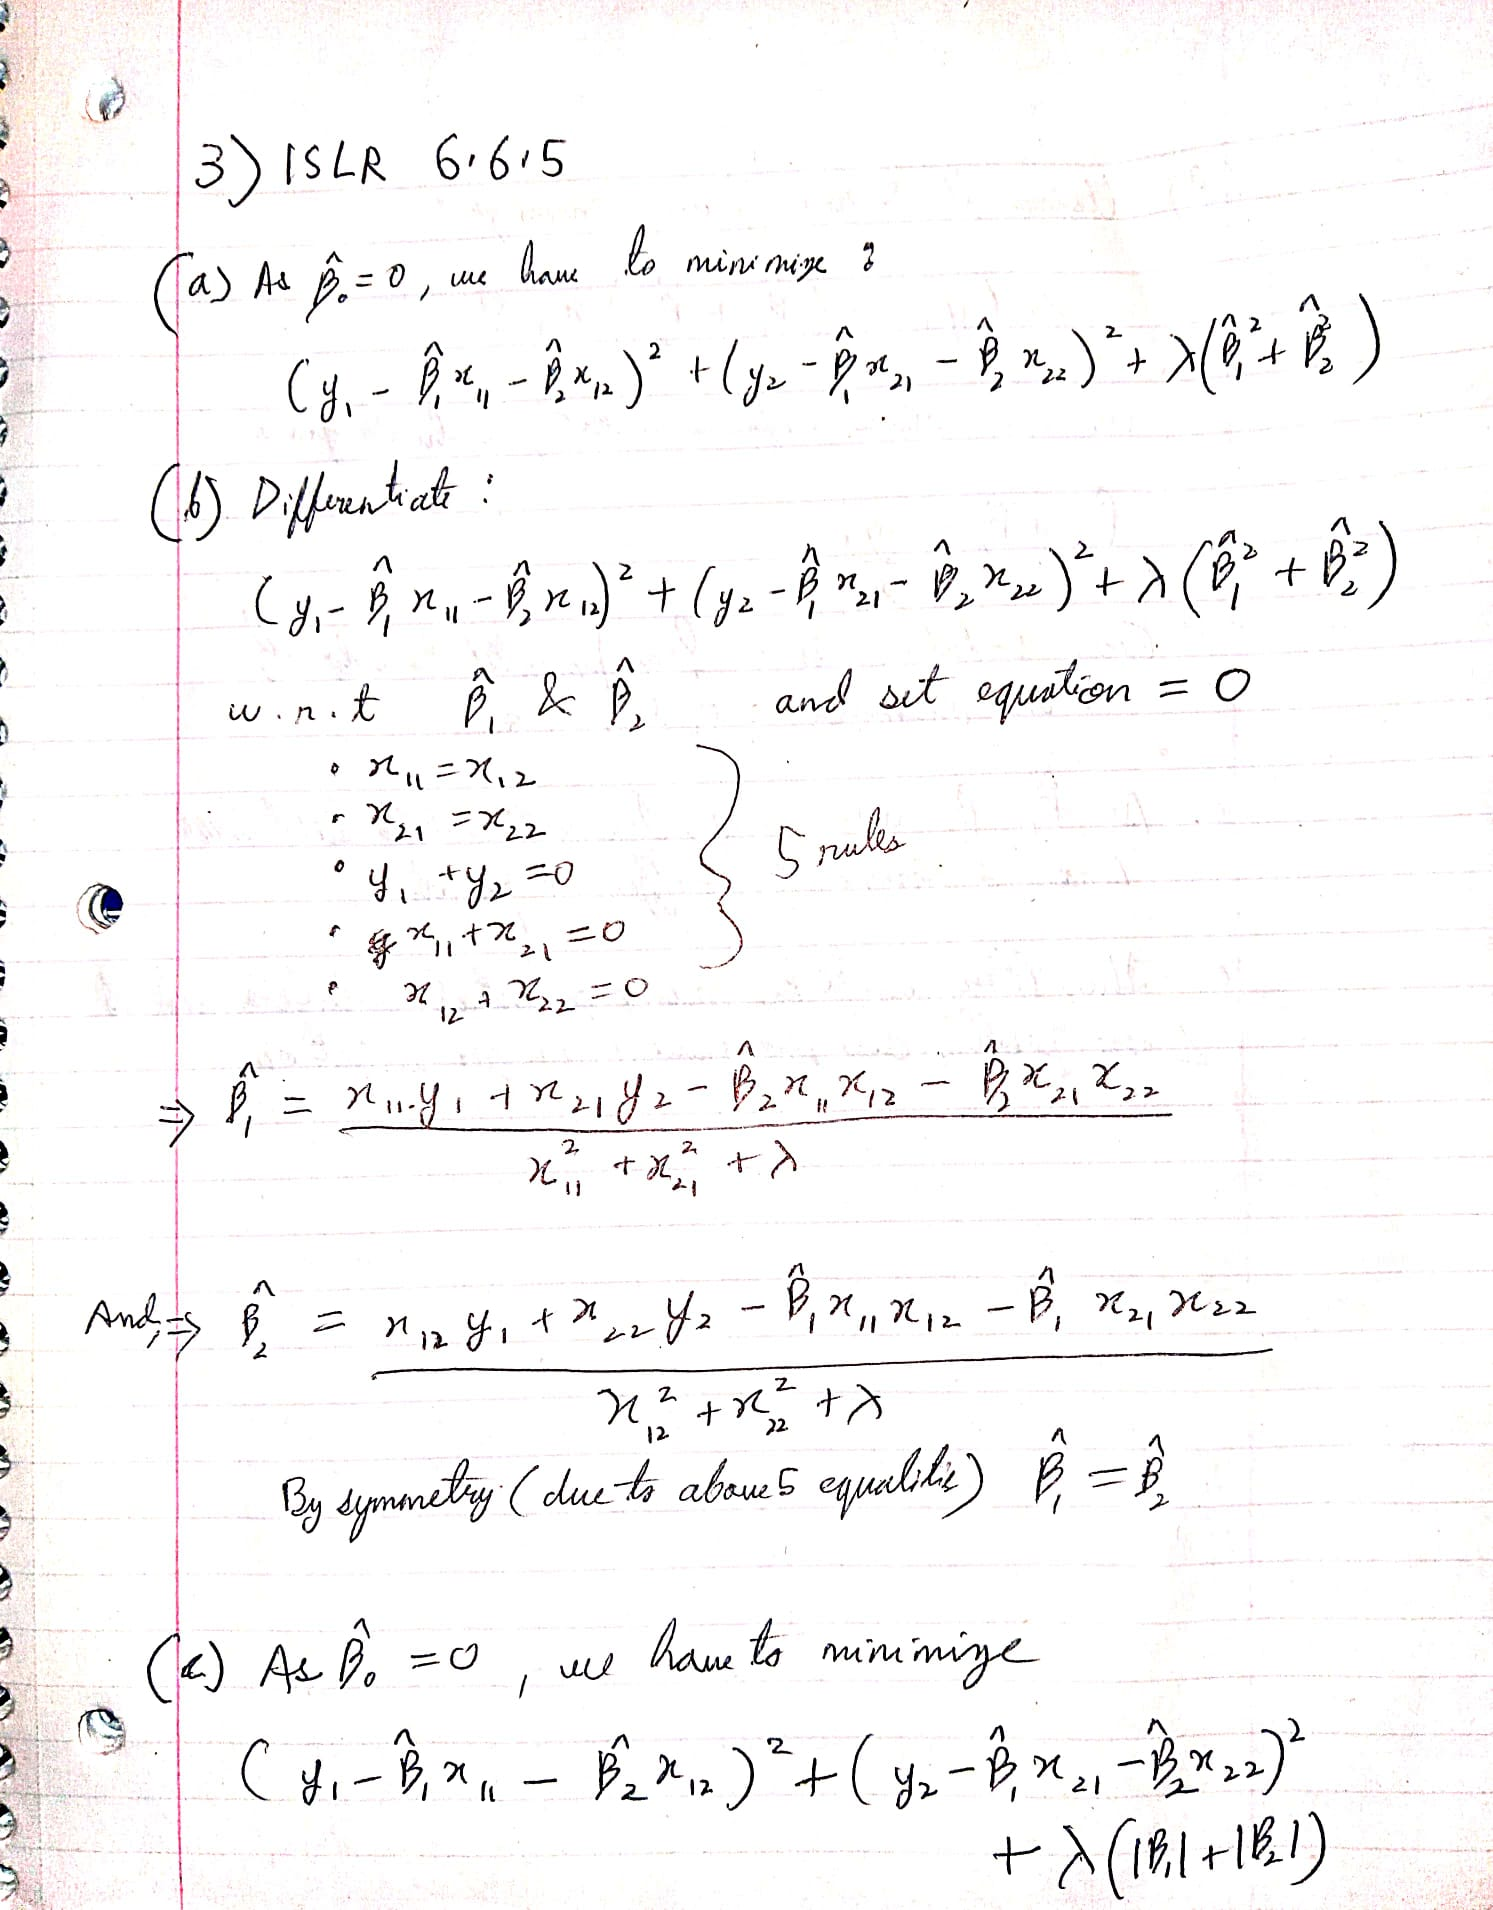

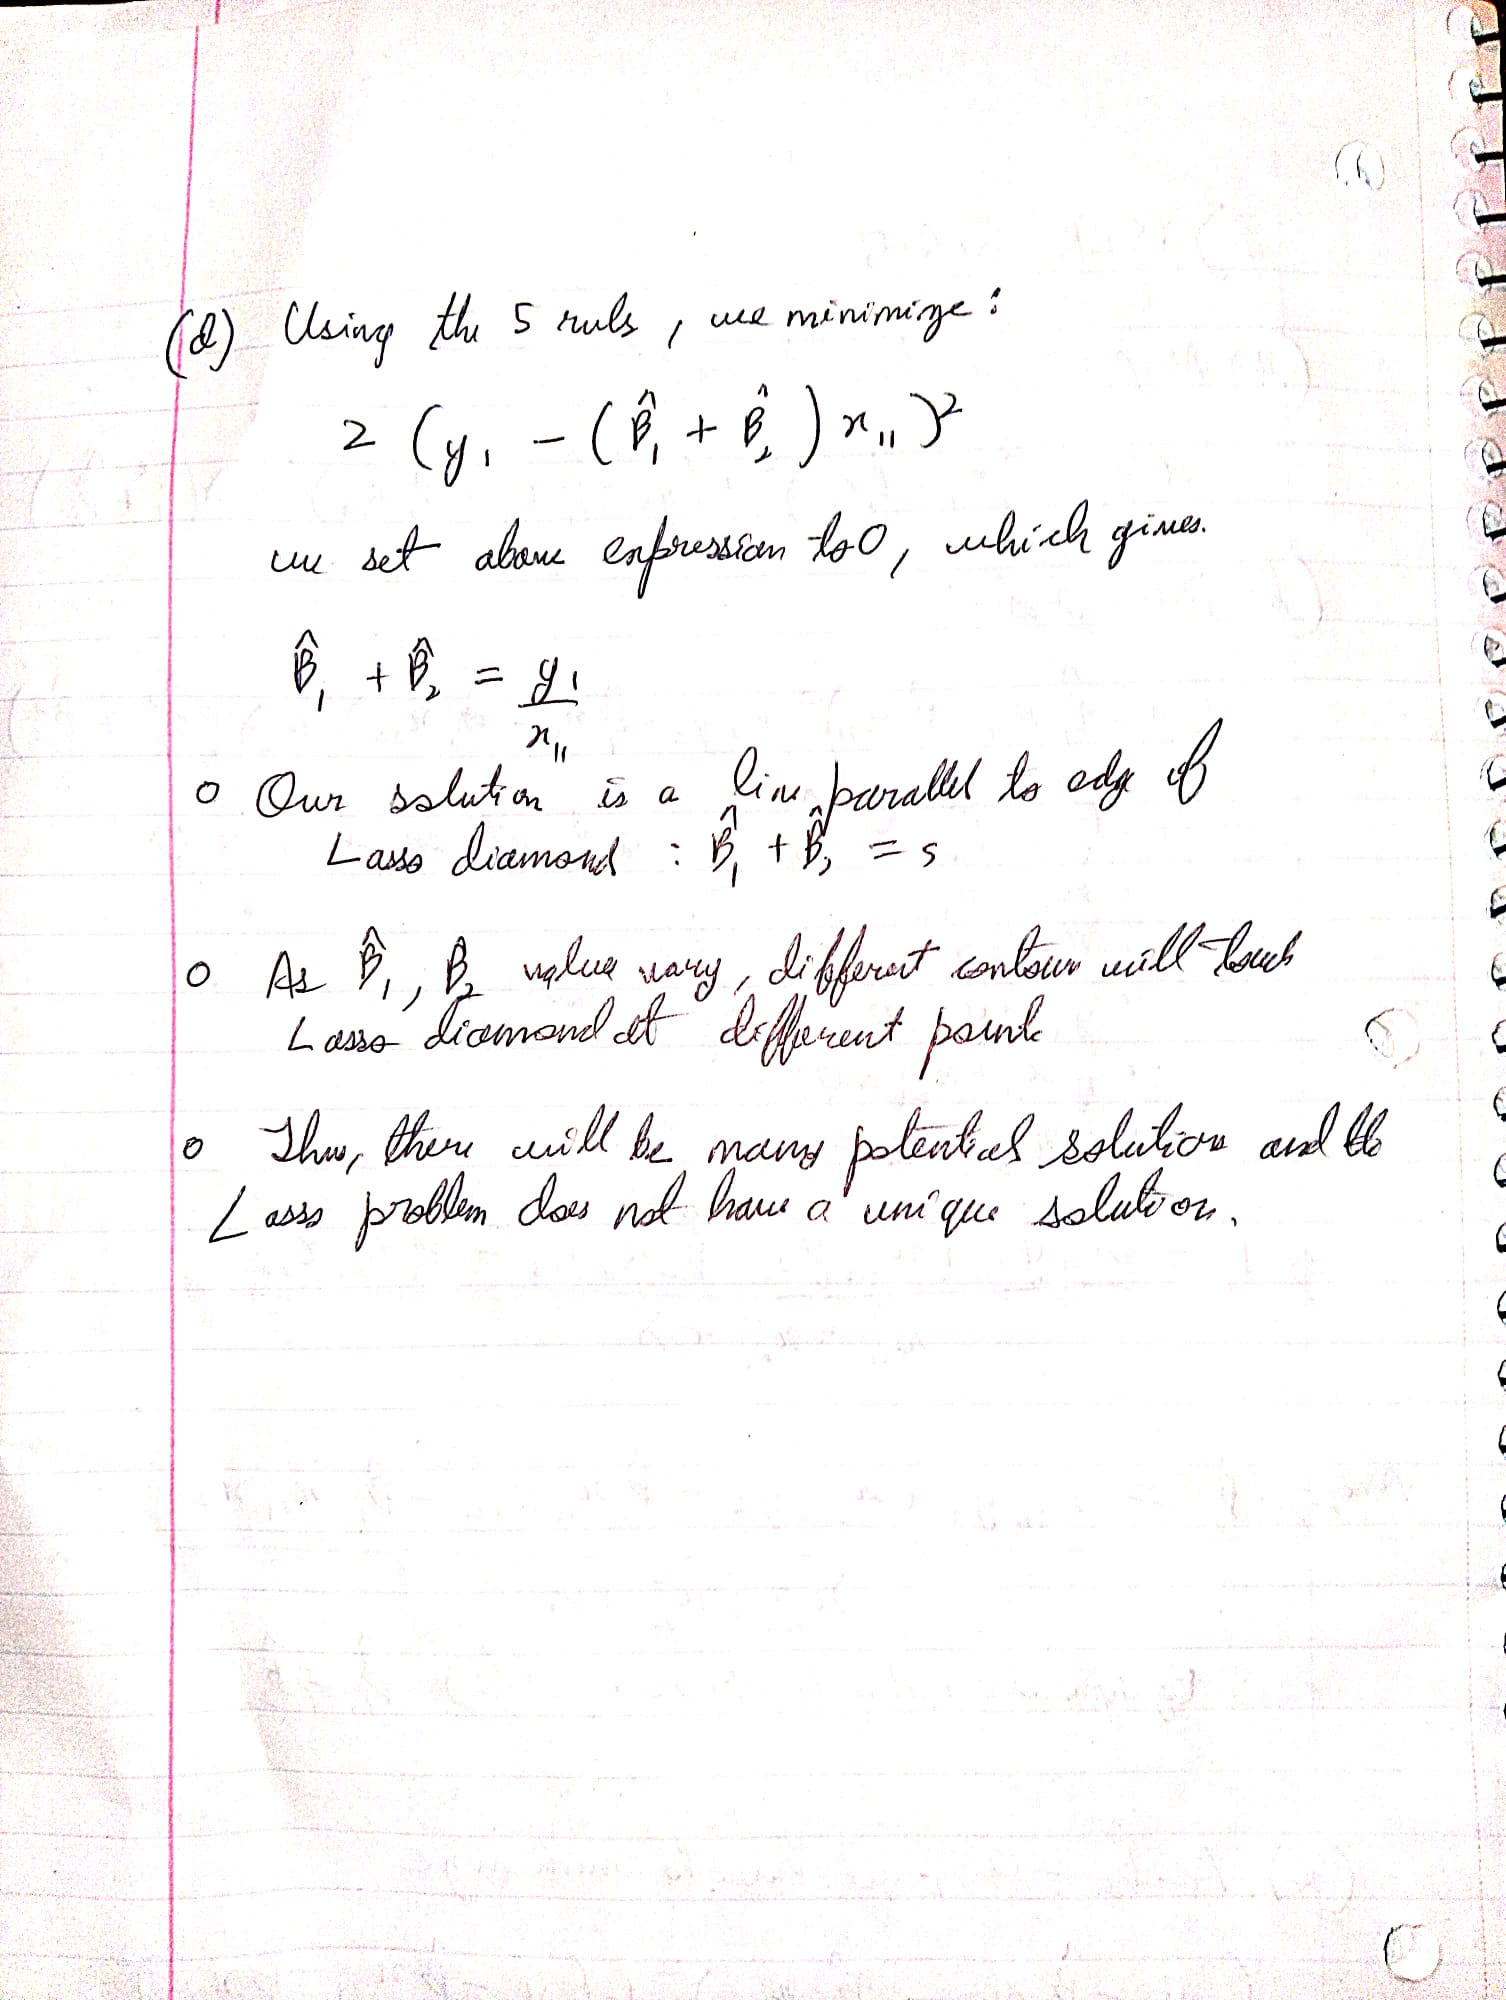

**4. ISLR 8.4.5**

**Majority Vote Approach**

There are 4 values where $P(Red \mid X) < 0.5$ and 6 values where $P(Red \mid X) \geqslant 0.5$ 

Hence, using the majority vote approach, <u>X is classified as Red.</u>


**Average Probability Approach**

The sum of the above 10 estimates are $0.1 + 0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75 = 4.5$.

Hence, the Average Probability is $4.5 / 10 = 0.45$. <u>Therefore, X is classified as Green.</u>

**5. ISLR 9.7.3**

**(a) We are given $n = 7$ observations in $p = 2$ dimensions. For each observation, there is an associated class label.**

In [79]:
data_dict = {'Feature1': [3, 2, 4, 1, 2, 4, 4], 
             'Feature2': [4, 2, 4, 4, 1, 3, 1], 
             'Label': ['red', 'red', 'red', 'red', 'blue', 'blue', 'blue']}
index_values = [1, 2, 3, 4, 5, 6, 7]

df_data = pd.DataFrame.from_dict(data_dict)
df_data.index = index_values

C:\Users\adity\AppData\Local\Temp\ipykernel_8416\215412702.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')


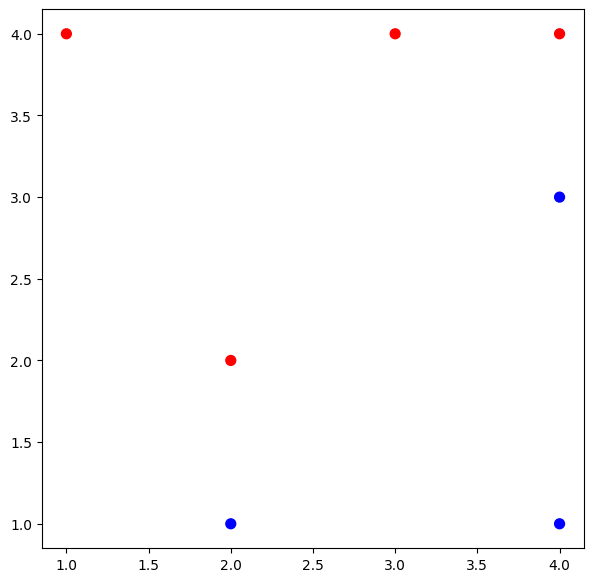

In [81]:
svc_model = SVC(kernel='linear', C=10000)
svc_model.fit(df_data.iloc[:, :-1], df_data.iloc[:, -1])

fig, ax_plot = plt.subplots(figsize=(7, 7))
ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')

**(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).**

As shown in the plot, the optimal separating hyperplane has to be: 
- between the observations (2,1) and (2,2), 
- and between the observations (4,3) and (4,4). 

- The equation is $X_{1} − X_{2} − 0.5 = 0$

C:\Users\adity\AppData\Local\Temp\ipykernel_8416\1504538542.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\adity\AppData\Local\Temp\ipykernel_8416\1504538542.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


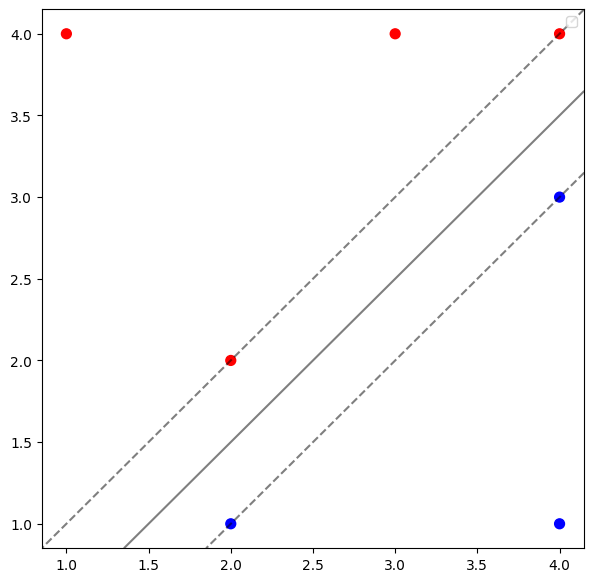

In [83]:
fig, ax_plot = plt.subplots(figsize=(7, 7))
ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')

x_limits = ax_plot.get_xlim()
y_limits = ax_plot.get_ylim()

x_values = np.linspace(x_limits[0], x_limits[1], 30)
y_values = np.linspace(y_limits[0], y_limits[1], 30)
YY, XX = np.meshgrid(y_values, x_values)
xy_grid = np.vstack([XX.ravel(), YY.ravel()]).T

decision_boundary = svc_model.decision_function(xy_grid).reshape(XX.shape)

contours = ax_plot.contour(XX, YY, decision_boundary, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

ax_plot.legend()
plt.show()

**(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if
$\beta_{0} + \beta_{1}X_{1} + \beta_{2}X_{2} > 0$, and classify to Blue otherwise.” Provide the values for $\beta_{0}$ , $\beta_{1}$ , and $\beta_{2}$.**


The classification rule is 

- If $X_{1} − X_{2} − 0.5<0$, we classify to Red 
- Otherswise we classify to Blue

**(d) On your sketch, indicate the margin for the maximal margin hyperplane.**

We believe that the hyperplane goes through the points (support vectors):
- (2,1): Observation 5
- (2,2): Observation 2 

The margin is $\frac{1}{4}$

**(e) Indicate the support vectors for the maximal margin classifier.**

The support vectors are the points 
- (2,1): Observation 5
- (2,2): Observation 2 
- (4,3): Observation 6 
- (4,4): Observation 3

A plot showing the support vectors is shown below.

C:\Users\adity\AppData\Local\Temp\ipykernel_8416\984116204.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')
C:\Users\adity\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


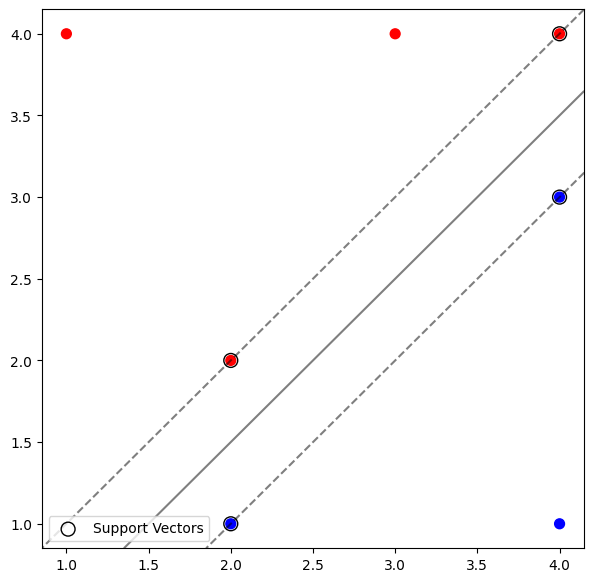

In [85]:
fig, ax_plot = plt.subplots(figsize=(7, 7))
ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')

x_limits = ax_plot.get_xlim()
y_limits = ax_plot.get_ylim()

x_values = np.linspace(x_limits[0], x_limits[1], 30)
y_values = np.linspace(y_limits[0], y_limits[1], 30)
YY, XX = np.meshgrid(y_values, x_values)
xy_grid = np.vstack([XX.ravel(), YY.ravel()]).T

decision_boundary = svc_model.decision_function(xy_grid).reshape(XX.shape)

contours = ax_plot.contour(XX, YY, decision_boundary, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

ax_plot.scatter(svc_model.support_vectors_[:, 0], svc_model.support_vectors_[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='black', label="Support Vectors")

ax_plot.legend()
plt.show()

**(f) Argue that a slight movement of the seventh observation would not aﬀect the maximal margin hyperplane.**

The 7th observation is $X_{1} = 4$ and $X_{2}=1$ and it is classified as Red. This would not affect the maximal margin hyperplane as it is not a support vector, as seen in the plot.

**(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.**

The optimal hyperplane is $X_{1} − X_{2} − 0.5 = 0$.

If we have a hyperplane which is $X_{1} − X_{2} − 0.3 = 0$, then this is not the optimal hyperplane.

NB: The optimal hyperplane and margin are drawn in red and the *non optimal hyperplane* is drawn in green.

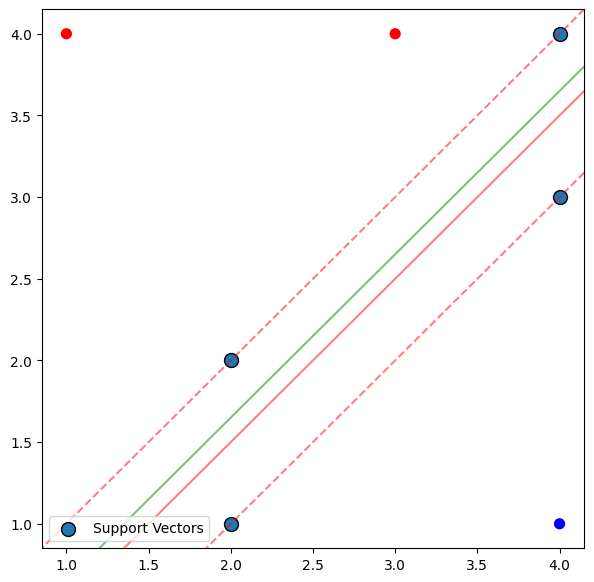

In [87]:
import warnings
warnings.filterwarnings("ignore")

fig, ax_plot = plt.subplots(figsize=(7, 7))
ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')

x_limits = ax_plot.get_xlim()
y_limits = ax_plot.get_ylim()

x_values = np.linspace(x_limits[0], x_limits[1], 30)
y_values = np.linspace(y_limits[0], y_limits[1], 30)
YY, XX = np.meshgrid(y_values, x_values)
xy_grid = np.vstack([XX.ravel(), YY.ravel()]).T

decision_boundary = svc_model.decision_function(xy_grid).reshape(XX.shape)

contours = ax_plot.contour(XX, YY, decision_boundary, colors='red', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

ax_plot.scatter(svc_model.support_vectors_[:, 0], svc_model.support_vectors_[:, 1], s=100, 
                linewidth=1, edgecolors='black', label="Support Vectors")

non_optimal_hyperplane = ax_plot.contour(XX, YY, decision_boundary - 0.3, colors='green', levels=[0], alpha=0.5, linestyles=['-'])

ax_plot.legend()
plt.show()


**(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.**

If we add a point (4,2) with the color red to the plot, the two classes are no longer separable by a hyperplane.

The extra observation is shown as a red triangle, to distinguish from the original observations.

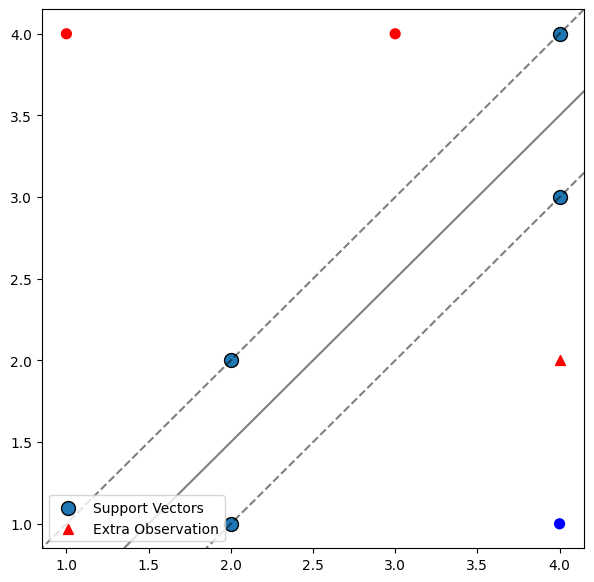

In [89]:
fig, ax_plot = plt.subplots(figsize=(7, 7))
ax_plot.scatter(df_data.iloc[:, 0], df_data.iloc[:, 1], c=df_data.iloc[:, -1], s=50, cmap='autumn')

x_limits = ax_plot.get_xlim()
y_limits = ax_plot.get_ylim()

x_values = np.linspace(x_limits[0], x_limits[1], 30)
y_values = np.linspace(y_limits[0], y_limits[1], 30)
YY, XX = np.meshgrid(y_values, x_values)
xy_grid = np.vstack([XX.ravel(), YY.ravel()]).T

decision_values = svc_model.decision_function(xy_grid).reshape(XX.shape)

contours = ax_plot.contour(XX, YY, decision_values, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

ax_plot.scatter(svc_model.support_vectors_[:, 0], svc_model.support_vectors_[:, 1], s=100, 
                linewidth=1, edgecolors='black', label="Support Vectors")

ax_plot.scatter([4.0], [2.0], color='red', marker='^', s=50, label="Extra Observation")

ax_plot.legend()
plt.show()